In [2]:
# Micrograd from scratch 
Re-implementing Andrej Karpathy's micrograd step by step.

In [52]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [295]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
        
    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # - self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)
        
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [296]:
import os

# Add both common Homebrew install paths
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"   # Apple Silicon Macs
os.environ["PATH"] += os.pathsep + "/usr/local/bin" 
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is the result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot
        

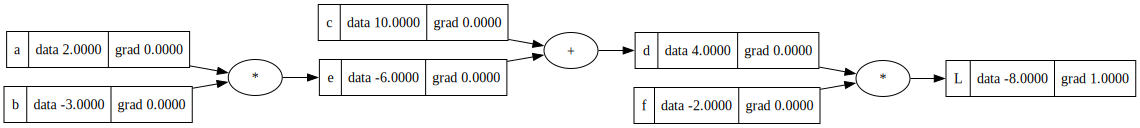

In [297]:
draw_dot(L)

In [298]:
L.grad = 1.0

In [299]:
def lol():
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data

    print((L2 - L1)/h)
lol()

6.000000000000227


In [300]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'
o.backward()

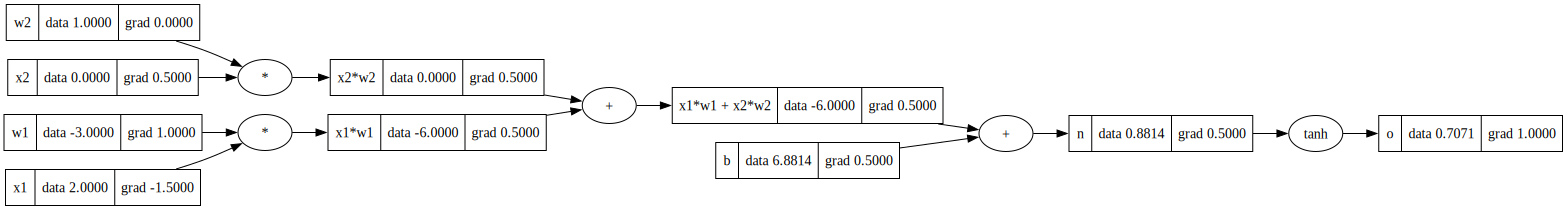

In [301]:
draw_dot(o)

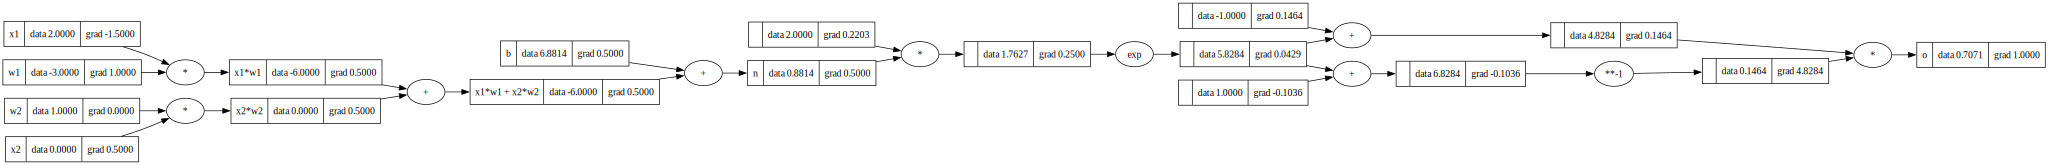

In [302]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label='o'
o.backward()
draw_dot(o)

In [325]:
import torch
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for i in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [405]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.8460815231736255)

In [406]:
n.parameters()

[Value(data=0.4695232859014844),
 Value(data=0.8936582592657527),
 Value(data=-0.8185932165562595),
 Value(data=-0.7931860419424259),
 Value(data=-0.19550583176803116),
 Value(data=-0.21279725259935045),
 Value(data=-0.0892373199930181),
 Value(data=-0.30597231021432947),
 Value(data=0.19852879514342958),
 Value(data=-0.436890334014314),
 Value(data=-0.6125750091025308),
 Value(data=-0.9385510314588126),
 Value(data=0.21084824196577645),
 Value(data=-0.5971238997379529),
 Value(data=-0.6264486563395162),
 Value(data=-0.9675119507188514),
 Value(data=0.6844114206800878),
 Value(data=-0.30267592381059205),
 Value(data=0.3709491293046878),
 Value(data=-0.5802406265602285),
 Value(data=0.13977146823134357),
 Value(data=-0.21718328932644004),
 Value(data=0.9087902006753605),
 Value(data=-0.566135739612291),
 Value(data=-0.9640685991757103),
 Value(data=-0.4801528022268682),
 Value(data=-0.14628456443712112),
 Value(data=0.4055124657601026),
 Value(data=-0.9271931091812815),
 Value(data=-0.5

In [410]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [431]:

for k in range(20):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)
    

0 9.802423240463388e-05
1 9.746344666715777e-05
2 9.690862304380673e-05
3 9.635966942373598e-05
4 9.581649555698178e-05
5 9.527901300814542e-05
6 9.474713511139431e-05
7 9.422077692684701e-05
8 9.369985519817059e-05
9 9.31842883114827e-05
10 9.267399625537881e-05
11 9.21689005821593e-05
12 9.166892437015235e-05
13 9.117399218712069e-05
14 9.068403005468722e-05
15 9.01989654138177e-05
16 8.971872709121257e-05
17 8.924324526671299e-05
18 8.877245144154162e-05
19 8.830627840750504e-05


In [432]:
ypred

[Value(data=0.9999999999999994),
 Value(data=-0.99999991677133),
 Value(data=-0.9906028579663507),
 Value(data=0.9999999999999994)]